In [ ]:
pip install opencv-python numpy matplotlib mtcnn keras-facenet tensorflow scipy scikit-learn

In [6]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [10]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr
    

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            # print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')


In [56]:
faceloading = FACELOADING("./dataset/")
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 109ms/step
Loaded successfully: 1
1/1 [==============================] - 0s 23ms/step
Loaded successfully: 1
1/1 [==============================] - 0s 22ms/step
Loaded successfully: 1
1/1 [==============================] - 0s 24ms/step
Loaded successfully: 4
1/1 [==============================] - 0s 20ms/step
Loaded successfully: 1
1/1 [==============================] - 0s 25ms/step
Loaded successfully: 2
1/1 [==============================] - 0s 24ms/step
Loaded successfully: 1
1/1 [==============================] - 0s 23ms/step
Loaded successfully: 1
1/1 [==============================] - 0s 23ms/step
Loaded successfully: 1
1/1 [==============================] - 0s 33ms/step
Loaded successfully: 1
1/1 [==============================] - 0s 22ms/step
Loaded successfully: 1
1/1 [==============================] - 0s 22ms/step
Loaded successfully: 2
1/1 [==============================] - 0s 22ms/step
Loaded successfully: 4
1/1 [===================

In [68]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [ ]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

In [70]:
np.savez_compressed('./faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

In [75]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
Y

array([  2,   3,   4,   5,   5,   5,   5,   6,   7,   7,   8,  10,   9,
        11,  12,  13,  13,  14,  14,  14,  14,  17,  18,  18,  18,  18,
        19,  22,  22,  22,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  21,  23,  23,
        15,  16,  24,  25,  25,  25,  25,  26,  26,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  36,  36,  36,  37,  37,  39,
        38,  38,  38,  40,  41,  41,  41,  42,  42,  43,  49,  50,  51,
        44,  45,  46,  46,  47,  48,  48,  52,  52,  52,  52,  52,  52,
        52,  52,  52,  52,  52,  52,  53,  54,  55,  56,  57,  58,  58,
        59,  60,  60,  60,  60,  60,  61,  62,  63,  64,  65,  66,  66,
        68,  68,  68,  69,  70,  72,  71,  73,  74,  74,  75,  67,  67,
        67,  67,  67,  76,   0,   1,  77,  78,  78,  78,  79,  79,  79,
        80,  81,  82,  83,  95,  96,  84,  84,  85,  86,  87,  87,  87,
        87,  87,  88,  89,  90,  90,  91,  92,  93,  94,  97,  9

13232

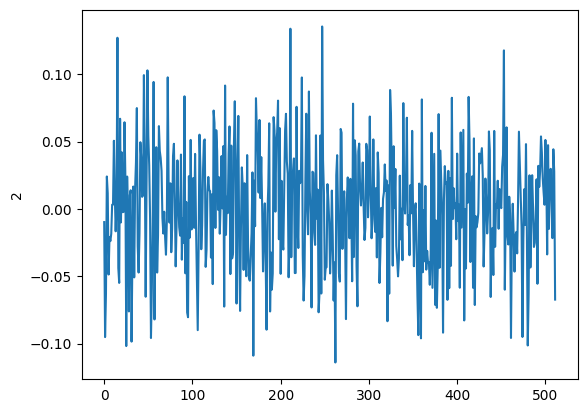

In [72]:
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])
len(EMBEDDED_X)

In [ ]:
Y 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

In [34]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

In [ ]:
accuracy_score(Y_test,ypreds_test)

import pickle
#save the model
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)

In [ ]:
t_im = cv.imread("./noor.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
detector = MTCNN()
x,y,w,h = detector.detect_faces(t_im)[0]['box']

In [ ]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

In [50]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [ ]:
ypreds

In [ ]:
encoder.inverse_transform(ypreds)